In [ ]:
# mount drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip "/content/drive/MyDrive/Grab-Posisi dataset/grab-posis-city=Singapore.zip"

Archive:  /content/drive/MyDrive/Grab-Posisi dataset/grab-posis-city=Singapore.zip
replace city=Singapore/part-00003-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# import relevant libraries

import pandas as pd
import datetime
import glob

In [ ]:
# load Grab Posisi Singapore dataset

sg_files = glob.glob("/content/city=Singapore")

df = pd.read_parquet(sg_files[0])

In [ ]:
# create a list of datasets that have accuracy > 10 and difference between consecutive timestemps > 30
# this list of datasets will be rejected and deleted from the main dataframe

df = df.sort_values(['trj_id', 'pingtimestamp'])
time_list = df["pingtimestamp"].values
id_list = df['trj_id'].values
accuracy_list = df['accuracy'].values

rejected_IDs = {}
ID_p = id_list[0]
for i in range(1,len(id_list)):
    ID_c = id_list[i]
    ping_diff = 0
    if ID_p == ID_c:
        ping_diff = time_list[i] - time_list[i-1]
    if (accuracy_list[i] > 10 or ping_diff > 30) and rejected_IDs.get(ID_c) == None:
        rejected_IDs[ID_c] = 1
    ID_p = id_list[i]
  
rej = {'trj_id': []}

for i in range(0, len(rejected_IDs)):
  rej['trj_id'].append(list(rejected_IDs.keys())[i])

In [ ]:
# deleting the rejected data from the dataframe

df = df.loc[df['trj_id'].isin(rej['trj_id'])]

In [ ]:
# filter data based on entry point and exit point of road that is to be examined

lat_min = 1.395492
lat_max = 1.396340
lng_min = 103.837983
lng_max = 103.841326

filtered = df.loc[(df['rawlat'] >= lat_min) & (df['rawlat'] <= lat_max) & (df['rawlng'] >= lng_min) & (df['rawlng'] <= lng_max)]

In [ ]:
# convert raw_lat and raw_lng in dataframe to lists of longitude and latitudes known as pings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pings = filtered[['rawlat', 'rawlng']].to_numpy()

pings

array([[  1.39552533, 103.8385612 ],
       [  1.39558575, 103.838741  ],
       [  1.39564628, 103.83891313],
       ...,
       [  1.39561664, 103.83973648],
       [  1.39556775, 103.83954238],
       [  1.39550654, 103.83935068]])

In [ ]:
# create heatmap to visualise the datapoints of the road that is examined

import folium
from folium import plugins
from branca.element import Figure

sg_lat = 1.290270
sg_lng = 103.851959

# create new figure
fig_peak_period = Figure(height = 550, width = 750)

# create new map
map_peak_period = folium.Map([sg_lat, sg_lng], zoom_start = 11,
                             min_zoom = 11, max_zoom = 16)
fig_peak_period.add_child(map_peak_period)

# create heatmap and add to map
plugins.HeatMap(pings, radius = 4, blur = 6).add_to(map_peak_period)

map_peak_period

In [ ]:
# create new columns in dataframe for day of week and date using pingtimestamp data

def format_datetime(df, col_name):
    # get datetime obj for all timestamps
    dt = df[col_name].apply(datetime.datetime.fromtimestamp)
    
    df["time"] = dt.apply(lambda x: x.time())
    df["day_of_week"] = dt.apply(lambda x: x.weekday())
    df["date"] = dt.apply(lambda x: x.strftime('%d'))
  
filtered_formatted = filtered.copy()

format_datetime(filtered_formatted, "pingtimestamp")

filtered_formatted

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,date
7862745,1000,car,ios,1554944295,1.395525,103.838561,21.450092,75,8.0,00:58:15,3,11
2994247,1000,car,ios,1554944296,1.395586,103.838741,21.032133,75,8.0,00:58:16,3,11
7860819,1000,car,ios,1554944297,1.395646,103.838913,20.185932,75,8.0,00:58:17,3,11
13104762,1000,car,ios,1554944298,1.395704,103.839080,20.311487,75,8.0,00:58:18,3,11
25828950,1000,car,ios,1554944299,1.395736,103.839261,20.185932,76,12.0,00:58:19,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...
3713665,9982,car,ios,1554827728,1.395709,103.840130,22.807310,256,8.0,16:35:28,1,09
22378085,9982,car,ios,1554827729,1.395665,103.839930,22.807310,256,8.0,16:35:29,1,09
22389212,9982,car,ios,1554827730,1.395617,103.839736,22.695948,256,8.0,16:35:30,1,09
18738602,9982,car,ios,1554827731,1.395568,103.839542,22.621355,255,8.0,16:35:31,1,09


In [ ]:
# sort data based on day of week then date

by_date = filtered_formatted.sort_values(['day_of_week', 'date'])
by_date

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,date
2195599,10371,car,ios,1554704953,1.396088,103.841311,23.020000,256,10.0,06:29:13,0,08
16972662,10371,car,ios,1554704954,1.396044,103.841103,23.580000,256,10.0,06:29:14,0,08
2188550,10371,car,ios,1554704955,1.396008,103.840890,24.080000,256,10.0,06:29:15,0,08
8052808,10371,car,ios,1554704956,1.395972,103.840672,25.020000,256,10.0,06:29:16,0,08
2201022,10371,car,ios,1554704957,1.395930,103.840450,25.209999,254,10.0,06:29:17,0,08
...,...,...,...,...,...,...,...,...,...,...,...,...
19406381,9709,car,android,1555887022,1.396195,103.840756,14.701508,77,4.0,22:50:22,6,21
3986220,9709,car,android,1555887023,1.396223,103.840886,15.124530,77,4.0,22:50:23,6,21
19404051,9709,car,android,1555887024,1.396253,103.841019,15.453078,77,4.0,22:50:24,6,21
22507558,9709,car,android,1555887025,1.396283,103.841156,15.768483,78,4.0,22:50:25,6,21


In [ ]:
# filter data based on all thursdays in April 2019: 4, 11, 18, 25 (but data's earliest date is 8 April and latest is 15 April)

thu = by_date.loc[by_date["day_of_week"] == 3] # 3 is actually thu
thu

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,date
7862745,1000,car,ios,1554944295,1.395525,103.838561,21.450092,75,8.0,00:58:15,3,11
2994247,1000,car,ios,1554944296,1.395586,103.838741,21.032133,75,8.0,00:58:16,3,11
7860819,1000,car,ios,1554944297,1.395646,103.838913,20.185932,75,8.0,00:58:17,3,11
13104762,1000,car,ios,1554944298,1.395704,103.839080,20.311487,75,8.0,00:58:18,3,11
25828950,1000,car,ios,1554944299,1.395736,103.839261,20.185932,76,12.0,00:58:19,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...
6486525,9970,car,android,1555580334,1.395959,103.840248,25.458513,75,4.0,09:38:54,3,18
9789872,9970,car,android,1555580335,1.396015,103.840469,25.592838,76,4.0,09:38:55,3,18
23168302,9970,car,android,1555580336,1.396069,103.840693,25.541120,76,4.0,09:38:56,3,18
4854160,9970,car,android,1555580337,1.396120,103.840917,25.167437,77,4.0,09:38:57,3,18


In [ ]:
# filter data based on all data from 9am to 10am

thu_9to10 = thu.loc[(thu["time"] > datetime.time(9,0,0)) & (thu["time"] < datetime.time(10,0,0))]
thu_9to10

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,date
15979719,18600,car,ios,1554975554,1.395524,103.838252,20.547256,78,12.0,09:39:14,3,11
18281328,18600,car,ios,1554975555,1.395570,103.838423,21.187529,78,12.0,09:39:15,3,11
13890352,18600,car,ios,1554975556,1.395620,103.838609,21.246841,78,12.0,09:39:16,3,11
15982677,18600,car,ios,1554975557,1.395667,103.838791,21.216553,78,12.0,09:39:17,3,11
13903467,18600,car,ios,1554975558,1.395710,103.838973,21.216553,77,12.0,09:39:18,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...
6486525,9970,car,android,1555580334,1.395959,103.840248,25.458513,75,4.0,09:38:54,3,18
9789872,9970,car,android,1555580335,1.396015,103.840469,25.592838,76,4.0,09:38:55,3,18
23168302,9970,car,android,1555580336,1.396069,103.840693,25.541120,76,4.0,09:38:56,3,18
4854160,9970,car,android,1555580337,1.396120,103.840917,25.167437,77,4.0,09:38:57,3,18


In [ ]:
# sort data

thu_9to10_sorted = thu_9to10.sort_values(['date'])
thu_9to10_sorted

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,date
15979719,18600,car,ios,1554975554,1.395524,103.838252,20.547256,78,12.0,09:39:14,3,11
8378736,62527,car,ios,1554975399,1.395617,103.839755,15.470000,332,10.0,09:36:39,3,11
27859363,62527,car,ios,1554975398,1.395648,103.839884,14.650000,332,10.0,09:36:38,3,11
15058997,62527,car,ios,1554975397,1.395680,103.840016,14.190000,332,10.0,09:36:37,3,11
2926991,62527,car,ios,1554975396,1.395714,103.840139,14.430000,333,10.0,09:36:36,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...
11722747,39663,car,ios,1555581598,1.396200,103.841072,18.140547,77,9.0,09:59:58,3,18
27430654,39663,car,ios,1555581599,1.396228,103.841222,17.723454,78,9.0,09:59:59,3,18
8086084,41188,car,android,1555579148,1.395505,103.838490,21.660000,75,3.9,09:19:08,3,18
5655783,39663,car,ios,1555581593,1.396011,103.840277,17.805481,76,7.0,09:59:53,3,18


In [ ]:
# split data to the two different thursdays (11 April adnd 18 April)

date_list = thu_9to10_sorted["date"].values
speed_list = thu_9to10_sorted["speed"].values

date_dict = {'date': ['11', '18'], 'avg_speed': []}

for i in range(0, len(date_dict['date'])):
  total_speed = 0
  count = 0
  for j in range(0, len(date_list)):
    if date_list[j] == date_dict['date'][i]:
      total_speed += speed_list[i]
      count += 1
  date_dict['avg_speed'].append(total_speed/count)

thu_9to10_11 = thu_9to10.loc[(thu_9to10["date"] == '11')]
thu_9to10_18 = thu_9to10.loc[(thu_9to10["date"] == '18')]

In [ ]:
# get average speed of the different date datasets

def getDayAvgspeed(lst, day): # note that day is a STRING!!

  thu_9to10_11 = lst.loc[(lst["date"] == day)]

  id_list_11 = thu_9to10_11.sort_values('trj_id')['trj_id'].values
  speed_list_11 = thu_9to10_11.sort_values('trj_id')['speed'].values

  L = []

  for i in range(0, len(id_list_11)):
      L.append([id_list_11[i], speed_list_11[i]])

  d = {}
  key = L[0][0]
  value = L[0][1]
  d[key] = value
  count = 1
  last_count = 0
  for i in range(1, len(L)):
    if L[i][0] == key:
      d[key] += L[i][1]
      count += 1
      last_count = count
    else:
      key = L[i][0]
      value = L[i][1]
      d[key] = value
      d[L[i-1][0]] /= count
      count = 1

  d[list(d.keys())[-1]] /= last_count

  return d

list_11 = getDayAvgspeed(thu_9to10, '11')
list_18 = getDayAvgspeed(thu_9to10, '18')

Text(0.5, 1.0, 'Average Speed of users on 11 April 2019 along SLE')

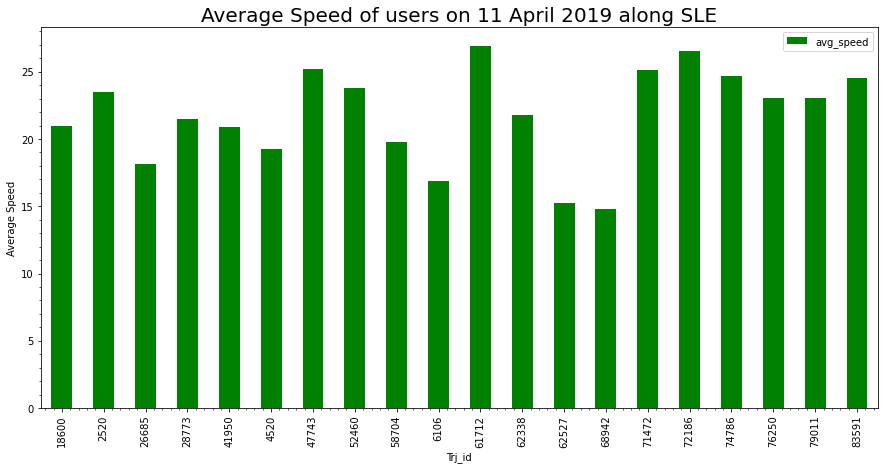

In [ ]:
# plot bar graph of users vs average speed for 11 April along the road examined

a = {'trj_id': [], 'avg_speed': []}

for i in range(0, len(list_11)):
  a['trj_id'].append(list(list_11.keys())[i])
  a['avg_speed'].append(list_11[list(list_11.keys())[i]])

g = pd.DataFrame(data = a)

# your plot setup
fig, ax= plt.subplots()

g.plot(kind="bar", ax=ax, color='g',figsize=(15,7), x = 'trj_id', y = 'avg_speed')

plt.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom='off')
ax.set_xlabel("Trj_id")
ax.set_ylabel("Average Speed")
ax.set_title(("Average Speed of users on 11 April 2019 along SLE"), fontsize=20)

Text(0.5, 1.0, 'Average Speed of users on 18 April 2019 along SLE')

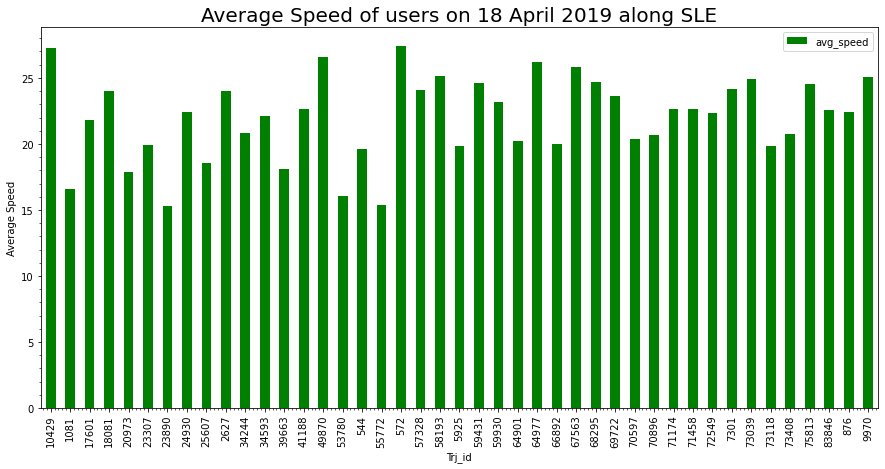

In [ ]:
# plot bar graph of users vs average speed for 18 April along the road examined

b = {'trj_id': [], 'avg_speed': []}

for i in range(0, len(list_18)):
  b['trj_id'].append(list(list_18.keys())[i])
  b['avg_speed'].append(list_18[list(list_18.keys())[i]])

gg = pd.DataFrame(data = b)

# your plot setup
fig, ax= plt.subplots()

gg.plot(kind="bar", ax=ax, color='g',figsize=(15,7), x = 'trj_id', y = 'avg_speed')

plt.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom='off')
ax.set_xlabel("Trj_id")
ax.set_ylabel("Average Speed")
ax.set_title(("Average Speed of users on 18 April 2019 along SLE"), fontsize=20)